**Standard Imports**

In [1]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

import seaborn as sns
sns.set_style('white')

# 1. Simulate sharp waveform

In [2]:
def periodic_gaussians(T, period, gauss_std,
                       Fs = 1000, delta_jitter = None,
                       amplitude_envelope = False, amplitude_envelope_filt_kwargs = {}):
    """Simulate a signal that is periodic gaussians
    
    Parameters
    ----------
    T : float
        length of time
    period
    gauss_std
    Fs
    delta_jitter
    amplitude_envelope : bool
        if True, the gaussian periodic gaussian is modulated by an amplitude envelope.
        This amplitude envelope is obtained by bandpass-filtering white noise 
    amplitude_envelope_filt_kwargs : dict
    
    Returns
    -------
    t
    lfp
    
    """
    
    # Process input
    dt = 1/float(Fs)
    t = np.arange(0,T,dt)
    N_samples = len(t)
    
    # Generate delta train
    delta_train = periodic_delta(N_samples, int(period*Fs), delta_jitter = delta_jitter)
    
    # Generate Gaussian
    gauss_len_time_half = gauss_std*3
    gauss_t = np.arange(-gauss_len_time_half,gauss_len_time_half+dt,dt)
    gauss_curve = gaussian(gauss_t, 0, gauss_std)
    
    # Convolve Gaussian with delta train
    lfp = np.convolve(delta_train, gauss_curve, mode='same') 
    # Make minimum -1 and max 1. Then subtract mean
    Ntaps = len(gauss_t)
    lfp = (lfp - np.min(lfp[Ntaps:-Ntaps]))/(np.max(lfp[Ntaps:-Ntaps])-np.min(lfp[Ntaps:-Ntaps]))*2 - 1
    # Subtract mean
    lfp -= np.mean(lfp)
    return t, lfp


def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    
    
def periodic_delta(N_samples, period, delta_jitter = None):
    """Simulate an oscillatory point process (1 event every period)
    noise is the standard deviation of the distribution of inter-spike-intervals (in samples)"""
    x = np.zeros(N_samples)
    spike_time = period-1
    while spike_time < N_samples:
        x[spike_time] = 1
        if delta_jitter is not None:
            spike_time += period + int(np.random.randn()*delta_jitter)
        else:
            spike_time += period
    return x


def simbrown(N):
    """Simulate a brown noise signal (power law distribution 1/f^2)
    with N samples"""
    wn = np.random.randn(N)
    return np.cumsum(wn)
    

def simfiltonef(T, f_range, Fs, N, samp_buffer = 10000):
    """ Simulate a band-pass filtered signal with 1/f^2 
    Input suggestions: f_range=(2,None), Fs=1000, N=1000
    
    Parameters
    ----------
    T : float
        length of time of simulated oscillation
    Fs : float
        oscillation sampling rate
    f_range : 2-element array (lo,hi)
        frequency range of simulated data
        if None: do not filter
    N : int
        order of filter
    """

    if f_range is None:
        # Do not filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs))
        return brownN
    elif f_range[1] is None:
        # High pass filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))
        # Filter
        nyq = Fs / 2.
        if N % 2 == 0:
            print('NOTE: Increased high-pass filter order by 1 in order to be odd')
            N += 1

        taps = sp.signal.firwin(N, f_range[0] / nyq, pass_zero=False)
        brownNf = sp.signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]

    else:
        # Bandpass filter
        # Generate 1/f^2 noise
        brownN = simbrown(int(T*Fs+N*2))
        # Filter
        nyq = Fs / 2.
        taps = sp.signal.firwin(N, np.array(f_range) / nyq, pass_zero=False)
        brownNf = sp.signal.filtfilt(taps, [1], brownN)
        return brownNf[N:-N]
    

def norm01(x):
    return (x - np.min(x))/(np.max(x)-np.min(x))

# Simulate nonsinusoidal oscillation

In [3]:
# SImulation parameters
Fs = 1000
delta_jitter = None
T = 10
f1 = 10
f1bw = 2
f1_range = (f1-f1bw,f1+f1bw)
period = 1/float(f1)
gauss_std_1 = .01
gauss_std_2 = .02

In [4]:
t, x_gauss_1 = periodic_gaussians(T, period, gauss_std_1,
                       Fs = Fs, delta_jitter = delta_jitter)
t, x_gauss_2 = periodic_gaussians(T, period, gauss_std_2,
                       Fs = Fs, delta_jitter = delta_jitter)

# Simulate 1/f noise

In [5]:
Ntaps = 500
randseed = 0
brown_bandpass = (2,200)
x_brown = simfiltonef(T, brown_bandpass, Fs, Ntaps)
x_brown = norm01(x_brown)

# Viz symmetric and asymmetric oscillation

(0, 1)

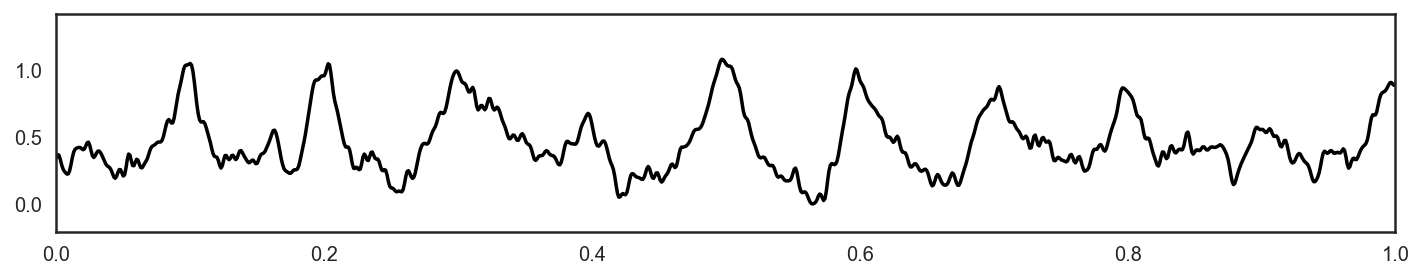

In [6]:
# Oscillation and noise is neural signal
x_gauss_weight = .3
x1 = x_gauss_1*x_gauss_weight + x_brown
x2 = x_gauss_2*x_gauss_weight + x_brown

plt.figure(figsize=(12,2))
plt.plot(t,x1, 'k-')
# plt.plot(t,x_gauss_1*x_gauss_weight, 'b-', alpha=.5)
# plt.plot(t,x_brown, 'r-', alpha=.5)
plt.xlim((0,1))

# Calculate phases

In [7]:
# 1. Low-band-pass filter
from misshapen.nonshape import bandpass_default
f_range = (8,12)
w = 3
xlo, filter_lo = bandpass_default(x1, f_range, Fs, w=w,rmv_edge=False)

# 2. High-band-pass filter
f_range = (15,25)
w = 5
xhi, filter_hi = bandpass_default(x1, f_range, Fs, w=w,rmv_edge=False)

# 3. Low freq phase
phalo = np.angle(sp.signal.hilbert(xlo))

# 4. High freq amp.
phahi = np.angle(sp.signal.hilbert(xhi))

# PPC

In [8]:
# Plot alpha phase vs. beta phase, color is probability of being in beta phase bin given in beta phase bin
def calc_ppc(pha1, pha2, Nphasebins = 50):
    ppc = np.zeros((Nphasebins,Nphasebins))
    pha_limits = np.linspace(-np.pi,np.pi,Nphasebins+1)
    for p1 in range(Nphasebins):
        pha1_true = np.logical_and(pha1>=pha_limits[p1], pha1<pha_limits[p1+1])
        for p2 in range(Nphasebins):
            pha2_true = np.logical_and(pha2>=pha_limits[p2], pha2<pha_limits[p2+1])
            ppc[p1,p2] = np.sum(np.logical_and(pha1_true,pha2_true))
    ppc = ppc/len(pha1)
    return ppc

In [9]:
Nphasebins = 50
ppc = calc_ppc(phalo,phahi,Nphasebins=Nphasebins)
pha_limits = np.linspace(-np.pi,np.pi,Nphasebins+1)[:Nphasebins]

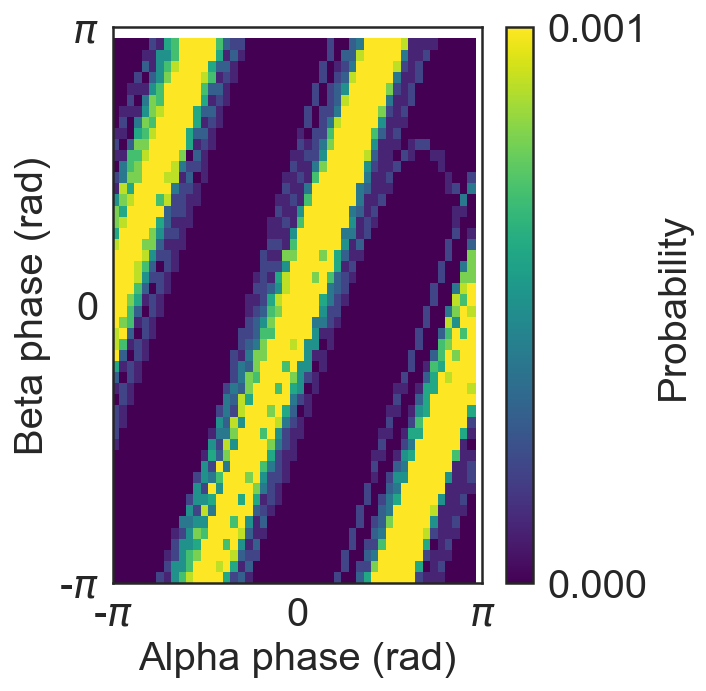

In [10]:
from matplotlib import cm
clim1 = [0,.001]

plt.figure(figsize=(5,5))
cax = plt.pcolor(pha_limits, pha_limits, ppc.T, cmap=cm.viridis)
cbar = plt.colorbar(cax, ticks=clim1)
cbar.ax.set_yticklabels(clim1,size=20)
cbar.ax.set_ylabel('Probability', size=20)
plt.clim(clim1)
plt.axis([pha_limits[0], pha_limits[-1], pha_limits[0], pha_limits[-1]])
plt.xlabel('Alpha phase (rad)', size=20)
plt.ylabel('Beta phase (rad)', size=20)
plt.xticks([-np.pi,0,np.pi],['-$\pi$','0','$\pi$'],size=20)
plt.yticks([-np.pi,0,np.pi],['-$\pi$','0','$\pi$'],size=20)
plt.tight_layout()

# 4. n:m phase-phase coupling (PPC)

In [11]:
def nmppc(x, flo, fhi, nm, Fs):
    """
    Calculate n:m phase-phase coupling between two oscillations
    Method from Palva et al., 2005 J Neuro
    * Morlet filter for the two frequencies
    * Use Hilbert to calculate phase and amplitude
    
    Parameters
    ----------
    x : np array
        time series of interest
    flo : 2-element list
        low and high cutoff frequencies for the low frequency band of interest
    fhi : 2-element list
        low and high cutoff frequencies for the high frequency band of interest
    nm : 2-element list of ints (n,m)
        n:m is the ratio of low frequency to high frequency (e.g. if flo ~= 8 and fhi ~= 24, then n:m = 1:3)
    Fs : float
        Sampling rate
        
    Returns
    -------
    plf : float
        n:m phase-phase coupling value (phase-locking factor)
    """
    
    from pacpy.pac import pa_series, _trim_edges
    phalo, _ = pa_series(x, x, flo, flo, fs = Fs)
    phahi, _ = pa_series(x, x, fhi, fhi, fs = Fs)
    phalo, phahi = _trim_edges(phalo, phahi)
    
    phadiffnm = phalo*nm[1] - phahi*nm[0]
    
    plf = np.abs(np.mean(np.exp(1j*phadiffnm)))
    return plf
    
    
def nmppcmany(x, floall, bw, M, Fs):
    """Calculate n:m coupling for many frequencies and values of 'm' for
    a single signal"""
    n_flo = len(floall)
    plfs = np.zeros((n_flo,M-1))
    for f in range(n_flo):
        for midx in range(M-1):
            m = midx + 2
            fhi = (floall[f]-bw,floall[f]+bw)
            flo = (floall[f]/m-bw/m,floall[f]/m+bw/m)
            plfs[f,midx] = nmppc(x, flo, fhi, (1,m),Fs)
            
    return plfs


def nmppcplot(plfs, floall, M, bw, clim1=(0,1)):
    import matplotlib.pyplot as plt
    from matplotlib import cm
    
    # Realign plfs
    plfs2 = np.zeros((len(floall)+1,M))
    plfs2[:len(floall),:M-1] = plfs

    plt.figure(figsize=(5,5))
    cax = plt.pcolor(range(2,M+2), np.append(floall,100), plfs2, cmap=cm.jet)
    cbar = plt.colorbar(cax, ticks=clim1)
    cbar.ax.set_yticklabels(clim1,size=20)
    cbar.ax.set_ylabel('Phase locking factor', size=20)
    plt.clim(clim1)
    plt.axis([2, M+1, floall[0],floall[-1]+10])
    plt.xlabel('M', size=20)
    plt.ylabel('Frequency (Hz)', size=20)
    ax = plt.gca()
    ax.set_yticks(np.array(floall)+bw)
    ax.set_yticklabels(["%d" % n for n in floall],size=20)
    plt.xticks(np.arange(2.5,M+1),["%d" % n for n in np.arange(2,M+1)],size=20)
    plt.tight_layout()

In [12]:
floall = [10, 20, 30, 40]
bw = 5
M = 3
plfs = nmppcmany(x1, floall, bw, M, Fs)

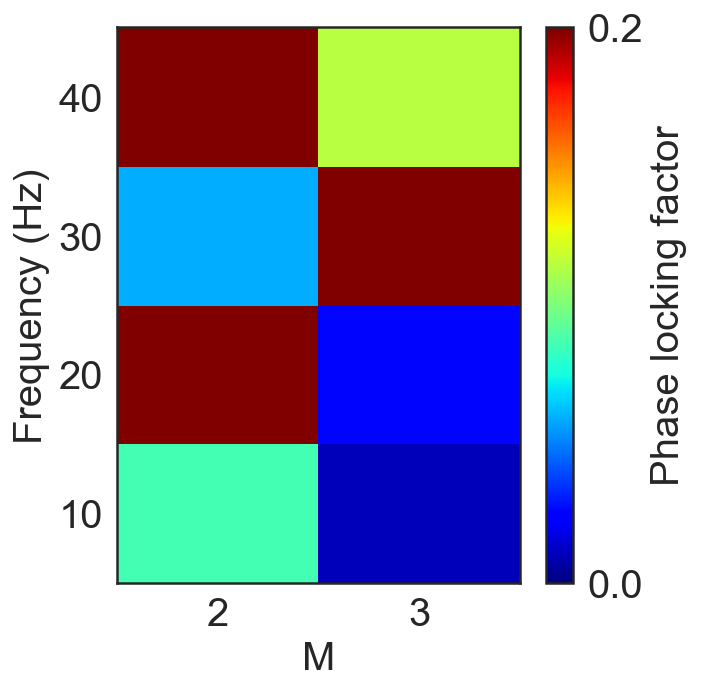

In [13]:
nmppcplot(plfs,floall,M,bw,clim1=(0,.2))